In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Von Bertalanffy growth model parameters
w_inf = 6       # Maximum possible biomass in kg
a = 1.113       # Growth constant (scales growth)
b = 1.097       # Shape parameter
c = 1.43        # Growth rate constant for open cage

# Initial conditions and costs
initial_biomass = 0.2            # Initial weight of fish in kg
initial_fish = 200000            # Initial number of fish in knot
harvesting_cost_per_kg = 4       # Cost of harvest per kg in NOK
feed_cost_per_kg_year = 5        # Cost of feed per kg per year in NOK
lice_treatment_cost = 1000000    # Cost of lice treatment
FCR = 1.25  # FCR for open cage
reduced_growth_treatment = 0.01  # How lice treatments will impact growth rate


# Host-parasite parameters
mu = 0.025                       # Intrinsic mortality of salmon (OpenKnot)
alpha = 0.1                      # Mortality from lice per salmon
mu_smoltification_inc = 0.2      # For open cage
weight_mort_inc = 0.001          # For open cage
lambda_growth = 7.0143           # Lice growth rate
lice_threshold = 0.5             # Lice per fish threshold for removal
beta1 = 0.0829                   # Beta distribution parameter for removal success
beta2 = 0.0281                   # Beta distribution parameter for removal success

# Mean-reversion parameters for spot price
mean_reversion_speed = 0.001
long_term_mean = 50
price_volatility = 0.2
initial_price = 50

# Simulation parameters
time_horizon = 3                 # in years
dt = 0.01                        # Time step
T = int(time_horizon / dt)       # Number of time steps
num_simulations = 10000           # Number of Monte Carlo paths
time = np.linspace(0, time_horizon, T)
r = 0.0303                       # Discount rate

In [38]:
# Define parameter ranges for scenario analysis
FCR_CCS_values = np.linspace(1.0, 1.25, num=10)
mu_smoltification_inc_css_values = np.linspace(0.2, 0.3, num=10)
weight_mort_inc_css_values = np.linspace(0.0006, 0.001, num=10)
c_CCS_values = np.linspace(1.43, 1.53, num=10)  # Growth rate constant for CCS
lambda_growth_values = np.linspace(5.0, 10.0, num=30)


In [30]:
# Adjusted biomass function
def biomass(t, w_inf, a, b, c):
    return w_inf * (a - b * np.exp(-c * t)) ** 3 + initial_biomass

# Simulate mean-reverting spot price (Ornstein-Uhlenbeck process)
def mean_reverting_price(P0, dt, T, mean_reversion_speed, long_term_mean, price_volatility):
    prices = np.zeros(T)
    prices[0] = P0
    for t in range(1, T):
        dP = mean_reversion_speed * (long_term_mean - prices[t-1]) * dt \
             + price_volatility * np.sqrt(dt) * np.random.randn()
        prices[t] = prices[t-1] + dP
    return prices

# Function to calculate dynamic mortality rate based on weight and lice count
def calculate_mortality_rate_dynamic(B_t, N_t, lice_per_fish_value, t, dt, mu, mu_smoltification_inc_css, weight_mort_inc_css):
    if t * dt <= 3/12:  # First three months
        if lice_per_fish_value > 0:
            mortality_rate_dynamic = mu_smoltification_inc  # For open cage
        else:
            mortality_rate_dynamic = mu_smoltification_inc_css  # For CCS
    elif t*dt <= 1:
        if lice_per_fish_value > 0:
            mortality_rate_dynamic = mu + alpha * lice_per_fish_value
        else:
            mortality_rate_dynamic = mu
    else: 
        if lice_per_fish_value > 0:
            mortality_rate_dynamic = mu + (weight_mort_inc * B_t ** 2) + alpha * lice_per_fish_value
        else:
            mortality_rate_dynamic = mu + (weight_mort_inc_css * B_t ** 2)
    return mortality_rate_dynamic

# Function to simulate fish population with cumulative mortality and calculate average dead weight
def simulate_paths(num_simulations, harvesting_cost_per_kg, feed_cost_per_kg_year, initial_lice_per_fish, FCR, mu, c, mu_smoltification_inc_css, weight_mort_inc_css, lice_treatment_cost, lambda_growth):
    # Initialize arrays to store simulation results
    all_values = np.zeros((num_simulations, T))
    harvesting_costs = np.zeros((num_simulations, T))
    feed_costs = np.zeros((num_simulations, T))
    treatment_costs = np.zeros((num_simulations, T))
    lice_per_fish = np.zeros((num_simulations, T))
    mortality_rate = np.zeros((num_simulations, T))
    total_mortality = np.zeros((num_simulations, T))
    average_dead_weight = np.zeros(num_simulations)  # To store average dead weight for each simulation
    B_t_array = np.zeros((num_simulations, T))  # Biomass at each time step
    D_t_array = np.zeros((num_simulations, T))  # Deaths at each time step

    for i in range(num_simulations):
        c_simulation = c
        N_t = initial_fish
        P_t = initial_lice_per_fish * N_t  # Initial lice population
        prices = mean_reverting_price(initial_price, dt, T, mean_reversion_speed, long_term_mean, price_volatility)
        cumulative_feed_cost = 0
        cumulative_treatment_cost = 0
        cumulative_death = 0

        for t in range(T):
            lice_per_fish_value = P_t / N_t if N_t > 0 else 0
            lice_per_fish[i, t] = lice_per_fish_value
            B_t = biomass(t * dt, w_inf, a, b, c_simulation)
            B_t_array[i, t] = B_t  # Store B_t

            # Calculate dynamic mortality rate
            mortality_rate_dynamic = calculate_mortality_rate_dynamic(B_t, N_t, lice_per_fish_value, t, dt, mu, mu_smoltification_inc_css, weight_mort_inc_css)
            mortality_rate[i, t] = mortality_rate_dynamic

            feed_cost_t = B_t * N_t * feed_cost_per_kg_year * dt * FCR

            # Calculate deaths
            D_t = N_t * mortality_rate_dynamic * dt
            D_t_array[i, t] = D_t  # Store D_t
            cumulative_death += D_t
            N_t -= D_t
            N_t = max(N_t, 0)  # Ensure N_t doesn't go below zero

            # Update lice population
            if N_t > 0:
                P_t += (lambda_growth * (N_t / initial_fish) - (mu + alpha * lice_per_fish_value)) * P_t * dt
            else:
                P_t = 0  # No fish left, so lice population is zero

            # Lice removal if the threshold is exceeded
            if lice_per_fish_value >= lice_threshold and N_t > 0:
                removal_success = 0.1 + 0.8 * np.random.beta(beta1, beta2)
                P_t *= (1 - removal_success) 
                # Small mortality from treatment
                mortality_from_treatment = N_t * (1 - np.random.uniform(0.995, 1.0))
                N_t -= mortality_from_treatment
                N_t = max(N_t, 0)
                cumulative_treatment_cost += lice_treatment_cost
                c_simulation *= (1 - reduced_growth_treatment)

                # Add treatment deaths to D_t_array
                D_t_array[i, t] += mortality_from_treatment
                # Update cumulative_death with treatment deaths
                cumulative_death += mortality_from_treatment

            # Calculate feed cost and cumulative feed cost
            cumulative_feed_cost += feed_cost_t
            feed_costs[i, t] = cumulative_feed_cost

            # Calculate cumulative treatment cost
            treatment_costs[i, t] = cumulative_treatment_cost
            total_mortality[i, t] = cumulative_death

            # Value at time t (Biomass * Number of Fish * Spot Price) minus costs
            all_values[i, t] = B_t * N_t * prices[t] - feed_costs[i, t] - treatment_costs[i, t]
            harvesting_costs[i, t] = B_t * N_t * harvesting_cost_per_kg

        # Calculate average dead weight for this simulation
        total_D_t = np.sum(D_t_array[i, :])
        if total_D_t > 0:
            average_dead_weight[i] = np.sum(D_t_array[i, :] * B_t_array[i, :]) / total_D_t
        else:
            average_dead_weight[i] = 0  # No deaths occurred

    return (all_values, harvesting_costs, feed_costs, lice_per_fish, treatment_costs,
            mortality_rate, total_mortality, B_t_array, D_t_array)

In [31]:
# LSMC function
def lsmc(paths, K, r, T, n_steps, B_t_array, D_t_array, poly_degree=3):
    dt = T / n_steps
    discount = np.exp(-r * dt)
    
    immediate_exercise_value = np.maximum(paths - K, 0)
    discounted_cash_flow = immediate_exercise_value[:, -1]
    exercise_times = np.full(paths.shape[0], n_steps)
    average_dead_weight = np.zeros(paths.shape[0])  # Fixed-size array for average dead weights
    total_mortality_rate = np.zeros(paths.shape[0])  # Fixed-size array for mortality rates

    for t in range(n_steps - 1, 0, -1):
        in_the_money = (paths[:, t] > K[:, t])
        paths_itm = np.where(in_the_money)[0]
        discounted_cash_flow *= discount

        if len(paths_itm) > 0:
            X = paths[paths_itm, t]
            Y = discounted_cash_flow[paths_itm]

            coeffs = np.polyfit(X, Y, deg=poly_degree)
            continuation_vals = np.polyval(coeffs, X)
            exercise = immediate_exercise_value[in_the_money, t] > continuation_vals
            discounted_cash_flow[in_the_money] = np.where(exercise, immediate_exercise_value[in_the_money, t], discounted_cash_flow[in_the_money])
            exercise_times[in_the_money] = np.where(exercise, t, exercise_times[in_the_money])

    for i in range(paths.shape[0]):
        exercise_time_index = int(exercise_times[i])
        total_D_t = np.sum(D_t_array[i, :exercise_time_index + 1])
        if total_D_t > 0:
            average_dead_weight[i] = np.sum(D_t_array[i, :exercise_time_index + 1] * B_t_array[i, :exercise_time_index + 1]) / total_D_t
        else:
            average_dead_weight[i] = 0
        total_mortality_rate[i] = total_D_t / initial_fish

    knot_value = np.mean(discounted_cash_flow) * discount
    avg_mortality_rate = np.mean(total_mortality_rate)
    return knot_value, exercise_times * dt, average_dead_weight, avg_mortality_rate

In [32]:
# # Generate Heat Map 1: FCR_CCS vs mu_smoltification_inc_css
# # [Include the code for Heat Map 1 here]
# # Fixed parameters for this heat map
# fixed_weight_mort_inc_css = 0.001  # Fixed weight_mort_inc_css
# fixed_c_CCS = 1.43                   # Fixed growth constant c_CCS

# # Initialize an array to store the value differences
# value_difference_1 = np.zeros((len(FCR_CCS_values), len(mu_smoltification_inc_css_values)))

# for i, FCR_CCS in enumerate(FCR_CCS_values):
#     for j, mu_smoltification_inc_css_current in enumerate(mu_smoltification_inc_css_values):
#         # Parameters for CCS
#         weight_mort_inc_css_current = fixed_weight_mort_inc_css
#         c_CCS_current = fixed_c_CCS

#         # Simulate CCS (without lice)
#         results_CCS = simulate_paths(
#             num_simulations, harvesting_cost_per_kg, feed_cost_per_kg_year, 0, FCR_CCS, mu, c_CCS_current, mu_smoltification_inc_css_current, weight_mort_inc_css_current, lice_treatment_cost, lambda_growth
#         )
#         (simulated_values_CCS, harvesting_costs_CCS, feed_costs_CCS, lice_per_fish_CCS, treatment_costs_CCS,
#          mortality_rate_CCS, cumulative_death_CCS, B_t_CCS, D_t_CCS) = results_CCS

#         knot_value_CCS, exercise_times_CCS, average_dead_weight_CCS, avg_mortality_rate_CCS = lsmc(
#             simulated_values_CCS, harvesting_costs_CCS, r, time_horizon, T, B_t_CCS, D_t_CCS
#         )

#         # Simulate open cage (with lice)
#         results_open = simulate_paths(
#             num_simulations, harvesting_cost_per_kg, feed_cost_per_kg_year, 0.001, FCR, mu, c, mu_smoltification_inc, weight_mort_inc, lice_treatment_cost, lambda_growth
#         )
#         (simulated_values_open, harvesting_costs_open, feed_costs_open, lice_per_fish_open, treatment_costs_open,
#          mortality_rate_open, cumulative_death_open, B_t_open, D_t_open) = results_open

#         knot_value_open, exercise_times_open, average_dead_weight_open, avg_mortality_rate_open = lsmc(
#             simulated_values_open, harvesting_costs_open, r, time_horizon, T, B_t_open, D_t_open
#         )

#         # Calculate value difference
#         value_diff = knot_value_CCS - knot_value_open
#         value_difference_1[i, j] = value_diff

#         print(f"FCR_CCS: {FCR_CCS:.2f}, Cumulative Mortality initial 3 months: {mu_smoltification_inc_css_current:.3f}, Value Difference: {value_diff:.2f}")

# # Generate heat map for Heat Map 1
# FCR_CCS_grid, mu_smoltification_inc_css_grid = np.meshgrid(mu_smoltification_inc_css_values, FCR_CCS_values)

# plt.figure(figsize=(8, 6))
# cp = plt.contourf(mu_smoltification_inc_css_grid, FCR_CCS_grid, value_difference_1, levels=20, cmap='coolwarm')
# plt.colorbar(cp)
# plt.title('Value Sensitivity\n Decreasing FCR over Increasing Initial Mortality')
# plt.xlabel('Feed Conversion Ratio')
# plt.ylabel('Cumulative Mortality initial 3 months')
# plt.show()


FCR_CCS: 1.00, weight_mort_inc_css: 0.0006, Value Difference: 8999121.12
FCR_CCS: 1.00, weight_mort_inc_css: 0.0006, Value Difference: 8900990.02
FCR_CCS: 1.00, weight_mort_inc_css: 0.0007, Value Difference: 8791635.58
FCR_CCS: 1.00, weight_mort_inc_css: 0.0007, Value Difference: 8694845.20
FCR_CCS: 1.00, weight_mort_inc_css: 0.0008, Value Difference: 8607599.97
FCR_CCS: 1.00, weight_mort_inc_css: 0.0008, Value Difference: 8486430.52
FCR_CCS: 1.00, weight_mort_inc_css: 0.0009, Value Difference: 8394688.91
FCR_CCS: 1.00, weight_mort_inc_css: 0.0009, Value Difference: 8296699.35
FCR_CCS: 1.00, weight_mort_inc_css: 0.0010, Value Difference: 8189524.94
FCR_CCS: 1.00, weight_mort_inc_css: 0.0010, Value Difference: 8079604.49
FCR_CCS: 1.03, weight_mort_inc_css: 0.0006, Value Difference: 8775864.93
FCR_CCS: 1.03, weight_mort_inc_css: 0.0006, Value Difference: 8699335.44
FCR_CCS: 1.03, weight_mort_inc_css: 0.0007, Value Difference: 8590169.84
FCR_CCS: 1.03, weight_mort_inc_css: 0.0007, Value D

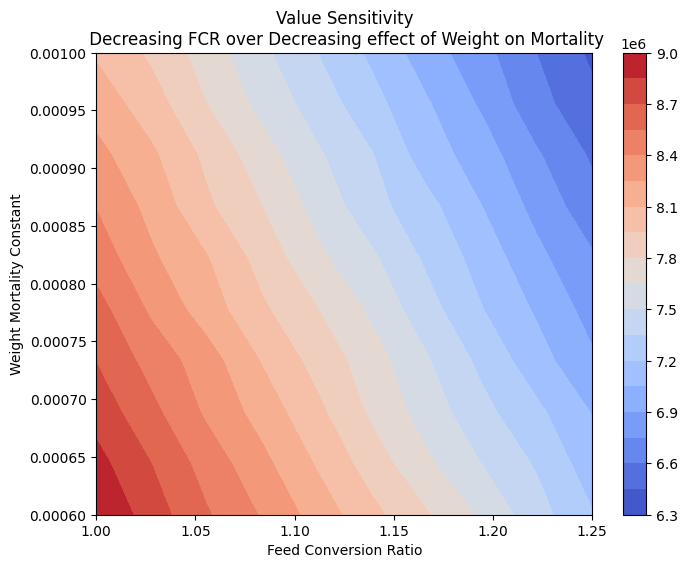

In [33]:
# Generate Heat Map 2: FCR_CCS vs weight_mort_inc_css
# [Include the code for Heat Map 2 here]

# Fixed parameters for this heat map
fixed_mu_smoltification_inc_css = 0.2  # Fixed mu_smoltification_inc_css
fixed_c_CCS = 1.43                       # Fixed growth constant c_CCS

# Initialize an array to store the value differences
value_difference_2 = np.zeros((len(FCR_CCS_values), len(weight_mort_inc_css_values)))

for i, FCR_CCS in enumerate(FCR_CCS_values):
    for j, weight_mort_inc_css_current in enumerate(weight_mort_inc_css_values):
        # Parameters for CCS
        mu_smoltification_inc_css_current = fixed_mu_smoltification_inc_css
        c_CCS_current = fixed_c_CCS

        # Simulate CCS (without lice)
        results_CCS = simulate_paths(
            num_simulations, harvesting_cost_per_kg, feed_cost_per_kg_year, 0, FCR_CCS, mu, c_CCS_current, mu_smoltification_inc_css_current, weight_mort_inc_css_current, lice_treatment_cost, lambda_growth
        )
        (simulated_values_CCS, harvesting_costs_CCS, feed_costs_CCS, lice_per_fish_CCS, treatment_costs_CCS,
         mortality_rate_CCS, cumulative_death_CCS, B_t_CCS, D_t_CCS) = results_CCS

        knot_value_CCS, exercise_times_CCS, average_dead_weight_CCS, avg_mortality_rate_CCS = lsmc(
            simulated_values_CCS, harvesting_costs_CCS, r, time_horizon, T, B_t_CCS, D_t_CCS
        )

        # Simulate open cage (with lice)
        results_open = simulate_paths(
            num_simulations, harvesting_cost_per_kg, feed_cost_per_kg_year, 0.001, FCR, mu, c, mu_smoltification_inc, weight_mort_inc, lice_treatment_cost, lambda_growth
        )
        (simulated_values_open, harvesting_costs_open, feed_costs_open, lice_per_fish_open, treatment_costs_open,
         mortality_rate_open, cumulative_death_open, B_t_open, D_t_open) = results_open

        knot_value_open, exercise_times_open, average_dead_weight_open, avg_mortality_rate_open = lsmc(
            simulated_values_open, harvesting_costs_open, r, time_horizon, T, B_t_open, D_t_open
        )

        # Calculate value difference
        value_diff = knot_value_CCS - knot_value_open
        value_difference_2[i, j] = value_diff

        print(f"FCR_CCS: {FCR_CCS:.2f}, weight_mort_inc_css: {weight_mort_inc_css_current:.4f}, Value Difference: {value_diff:.2f}")

# Generate heat map for Heat Map 2
FCR_CCS_grid, weight_mort_inc_css_grid = np.meshgrid(weight_mort_inc_css_values, FCR_CCS_values)

plt.figure(figsize=(8, 6))
cp = plt.contourf(weight_mort_inc_css_grid, FCR_CCS_grid, value_difference_2, levels=20, cmap='coolwarm')
plt.colorbar(cp)
plt.title('Value Sensitivity\n Decreasing FCR over Decreasing effect of Weight on Mortality')
plt.xlabel('Feed Conversion Ratio')
plt.ylabel('Weight Mortality Constant')
plt.show()


c_CCS: 1.43, weight_mort_inc_css: 0.0006, Value Difference: 7198017.95
c_CCS: 1.43, weight_mort_inc_css: 0.0006, Value Difference: 7127765.68
c_CCS: 1.43, weight_mort_inc_css: 0.0007, Value Difference: 7024143.49
c_CCS: 1.43, weight_mort_inc_css: 0.0007, Value Difference: 6921341.81
c_CCS: 1.43, weight_mort_inc_css: 0.0008, Value Difference: 6877845.16
c_CCS: 1.43, weight_mort_inc_css: 0.0008, Value Difference: 6801310.87
c_CCS: 1.43, weight_mort_inc_css: 0.0009, Value Difference: 6688599.34
c_CCS: 1.43, weight_mort_inc_css: 0.0009, Value Difference: 6566813.21
c_CCS: 1.43, weight_mort_inc_css: 0.0010, Value Difference: 6520926.43
c_CCS: 1.43, weight_mort_inc_css: 0.0010, Value Difference: 6440944.91
c_CCS: 1.44, weight_mort_inc_css: 0.0006, Value Difference: 7317448.63
c_CCS: 1.44, weight_mort_inc_css: 0.0006, Value Difference: 7247238.46
c_CCS: 1.44, weight_mort_inc_css: 0.0007, Value Difference: 7131414.05
c_CCS: 1.44, weight_mort_inc_css: 0.0007, Value Difference: 7035829.07
c_CCS:

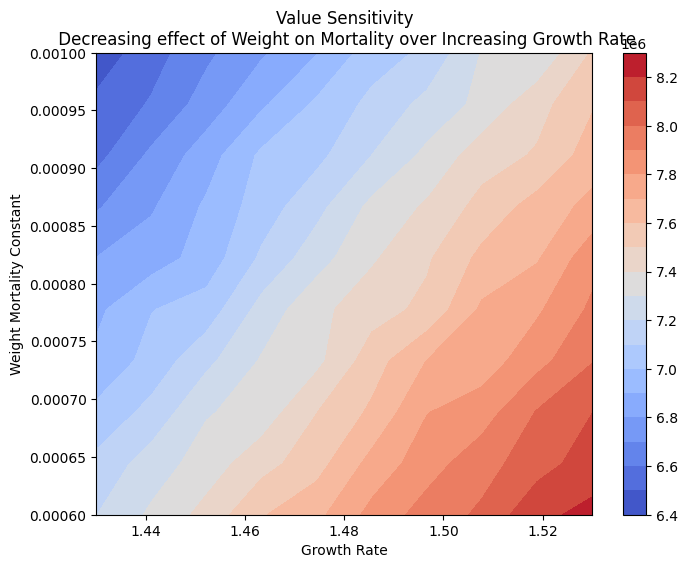

In [36]:
# Generate Heat Map 3: c_CCS vs weight_mort_inc_css
# [Include the code for Heat Map 3 here]

# Fixed parameters for this heat map
fixed_FCR_CCS = 1.25                 # Fixed FCR_CCS
fixed_mu_smoltification_inc_css = 0.2  # Fixed mu_smoltification_inc_css

# Initialize an array to store the value differences
value_difference_3 = np.zeros((len(c_CCS_values), len(weight_mort_inc_css_values)))

for i, c_CCS_current in enumerate(c_CCS_values):
    for j, weight_mort_inc_css_current in enumerate(weight_mort_inc_css_values):
        # Parameters for CCS
        mu_smoltification_inc_css_current = fixed_mu_smoltification_inc_css
        FCR_CCS_current = fixed_FCR_CCS

        # Simulate CCS (without lice)
        results_CCS = simulate_paths(
            num_simulations, harvesting_cost_per_kg, feed_cost_per_kg_year, 0, FCR_CCS_current, mu, c_CCS_current, mu_smoltification_inc_css_current, weight_mort_inc_css_current, lice_treatment_cost, lambda_growth
        )
        (simulated_values_CCS, harvesting_costs_CCS, feed_costs_CCS, lice_per_fish_CCS, treatment_costs_CCS,
         mortality_rate_CCS, cumulative_death_CCS, B_t_CCS, D_t_CCS) = results_CCS

        knot_value_CCS, exercise_times_CCS, average_dead_weight_CCS, avg_mortality_rate_CCS = lsmc(
            simulated_values_CCS, harvesting_costs_CCS, r, time_horizon, T, B_t_CCS, D_t_CCS
        )

        # Simulate open cage (with lice)
        results_open = simulate_paths(
            num_simulations, harvesting_cost_per_kg, feed_cost_per_kg_year, 0.001, FCR, mu, c, mu_smoltification_inc, weight_mort_inc, lice_treatment_cost, lambda_growth
        )
        (simulated_values_open, harvesting_costs_open, feed_costs_open, lice_per_fish_open, treatment_costs_open,
         mortality_rate_open, cumulative_death_open, B_t_open, D_t_open) = results_open

        knot_value_open, exercise_times_open, average_dead_weight_open, avg_mortality_rate_open = lsmc(
            simulated_values_open, harvesting_costs_open, r, time_horizon, T, B_t_open, D_t_open
        )

        # Calculate value difference
        value_diff = knot_value_CCS - knot_value_open
        value_difference_3[i, j] = value_diff

        print(f"c_CCS: {c_CCS_current:.2f}, weight_mort_inc_css: {weight_mort_inc_css_current:.4f}, Value Difference: {value_diff:.2f}")

# Generate heat map for Heat Map 3
c_CCS_grid, weight_mort_inc_css_grid = np.meshgrid(weight_mort_inc_css_values, c_CCS_values)

plt.figure(figsize=(8, 6))
cp = plt.contourf(weight_mort_inc_css_grid, c_CCS_grid, value_difference_3, levels=20, cmap='coolwarm')
plt.colorbar(cp)
plt.title('Value Sensitivity\n Decreasing effect of Weight on Mortality over Increasing Growth Rate')
plt.xlabel('Growth Rate')
plt.ylabel('Weight Mortality Constant')
plt.show()

c_CCS: 0.20, weight_mort_inc_css: 0.0006, Value Difference: 7122164.55
c_CCS: 0.20, weight_mort_inc_css: 0.0006, Value Difference: 7225299.24
c_CCS: 0.20, weight_mort_inc_css: 0.0007, Value Difference: 6939155.07
c_CCS: 0.20, weight_mort_inc_css: 0.0007, Value Difference: 6903365.26
c_CCS: 0.20, weight_mort_inc_css: 0.0008, Value Difference: 6714333.73
c_CCS: 0.20, weight_mort_inc_css: 0.0008, Value Difference: 6753671.51
c_CCS: 0.20, weight_mort_inc_css: 0.0009, Value Difference: 6634583.40
c_CCS: 0.20, weight_mort_inc_css: 0.0009, Value Difference: 6646802.77
c_CCS: 0.20, weight_mort_inc_css: 0.0010, Value Difference: 6567127.23
c_CCS: 0.20, weight_mort_inc_css: 0.0010, Value Difference: 6349033.38
c_CCS: 0.20, weight_mort_inc_css: 0.0006, Value Difference: 7195883.84
c_CCS: 0.20, weight_mort_inc_css: 0.0006, Value Difference: 7196354.93
c_CCS: 0.20, weight_mort_inc_css: 0.0007, Value Difference: 7139268.46
c_CCS: 0.20, weight_mort_inc_css: 0.0007, Value Difference: 7074730.63
c_CCS:

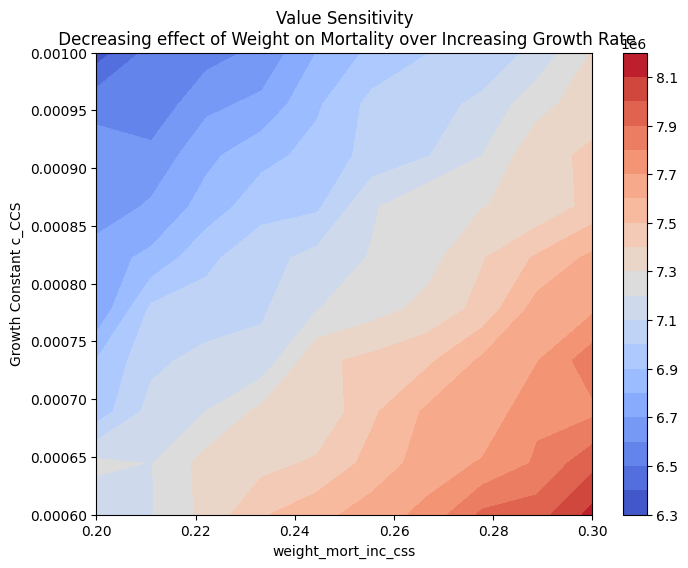

In [ ]:
# # Generate Heat Map 4: mu_smoltification_inc vs weight_mort_inc_css
# # [Include the code for Heat Map 3 here]

# # Fixed parameters for this heat map
# fixed_FCR_CCS = 1.25                 # Fixed FCR_CCS
# fixed_c_CCS = 1.43  # Fixed mu_smoltification_inc_css

# # Initialize an array to store the value differences
# value_difference_3 = np.zeros((len(c_CCS_values), len(weight_mort_inc_css_values)))

# for i, mu_smoltification_inc in enumerate(mu_smoltification_inc_css_values):
#     for j, weight_mort_inc_css_current in enumerate(weight_mort_inc_css_values):
#         # Parameters for CCS
#         c_CCS_current = fixed_c_CCS
#         FCR_CCS_current = fixed_FCR_CCS

#         # Simulate CCS (without lice)
#         results_CCS = simulate_paths(
#             num_simulations, harvesting_cost_per_kg, feed_cost_per_kg_year, 0, FCR_CCS_current, mu, c_CCS_current, mu_smoltification_inc_css_current, weight_mort_inc_css_current, lice_treatment_cost, lambda_growth
#         )
#         (simulated_values_CCS, harvesting_costs_CCS, feed_costs_CCS, lice_per_fish_CCS, treatment_costs_CCS,
#          mortality_rate_CCS, cumulative_death_CCS, B_t_CCS, D_t_CCS) = results_CCS

#         knot_value_CCS, exercise_times_CCS, average_dead_weight_CCS, avg_mortality_rate_CCS = lsmc(
#             simulated_values_CCS, harvesting_costs_CCS, r, time_horizon, T, B_t_CCS, D_t_CCS
#         )

#         # Simulate open cage (with lice)
#         results_open = simulate_paths(
#             num_simulations, harvesting_cost_per_kg, feed_cost_per_kg_year, 0.001, FCR, mu, c, mu_smoltification_inc, weight_mort_inc, lice_treatment_cost, lambda_growth
#         )
#         (simulated_values_open, harvesting_costs_open, feed_costs_open, lice_per_fish_open, treatment_costs_open,
#          mortality_rate_open, cumulative_death_open, B_t_open, D_t_open) = results_open

#         knot_value_open, exercise_times_open, average_dead_weight_open, avg_mortality_rate_open = lsmc(
#             simulated_values_open, harvesting_costs_open, r, time_horizon, T, B_t_open, D_t_open
#         )

#         # Calculate value difference
#         value_diff = knot_value_CCS - knot_value_open
#         value_difference_3[i, j] = value_diff

#         print(f"c_CCS: {mu_smoltification_inc_css_current:.2f}, weight_mort_inc_css: {weight_mort_inc_css_current:.4f}, Value Difference: {value_diff:.2f}")

# # Generate heat map for Heat Map 3
# mu_smoltification_inc_css_grid, weight_mort_inc_css_grid = np.meshgrid(weight_mort_inc_css_values, mu_smoltification_inc_css_values)

# plt.figure(figsize=(8, 6))
# cp = plt.contourf(weight_mort_inc_css_grid, mu_smoltification_inc_css_grid, value_difference_3, levels=20, cmap='coolwarm')
# plt.colorbar(cp)
# plt.title('Value Sensitivity\n Decreasing effect of Weight on Mortality over Increasing Growth Rate')
# plt.xlabel('weight_mort_inc_css')
# plt.ylabel('Growth Constant c_CCS')
# plt.show()


FCR_CCS: 1.00, lice_treatment_cost: 500000, Value Difference: 7510950.08
FCR_CCS: 1.00, lice_treatment_cost: 555556, Value Difference: 7651174.36
FCR_CCS: 1.00, lice_treatment_cost: 611111, Value Difference: 7796825.00
FCR_CCS: 1.00, lice_treatment_cost: 666667, Value Difference: 7949409.08
FCR_CCS: 1.00, lice_treatment_cost: 722222, Value Difference: 8197254.69
FCR_CCS: 1.00, lice_treatment_cost: 777778, Value Difference: 8312698.59
FCR_CCS: 1.00, lice_treatment_cost: 833333, Value Difference: 8448941.73
FCR_CCS: 1.00, lice_treatment_cost: 888889, Value Difference: 8588762.90
FCR_CCS: 1.00, lice_treatment_cost: 944444, Value Difference: 8811991.75
FCR_CCS: 1.00, lice_treatment_cost: 1000000, Value Difference: 8834471.22
FCR_CCS: 1.03, lice_treatment_cost: 500000, Value Difference: 7325640.06
FCR_CCS: 1.03, lice_treatment_cost: 555556, Value Difference: 7543889.88
FCR_CCS: 1.03, lice_treatment_cost: 611111, Value Difference: 7642697.31
FCR_CCS: 1.03, lice_treatment_cost: 666667, Value 

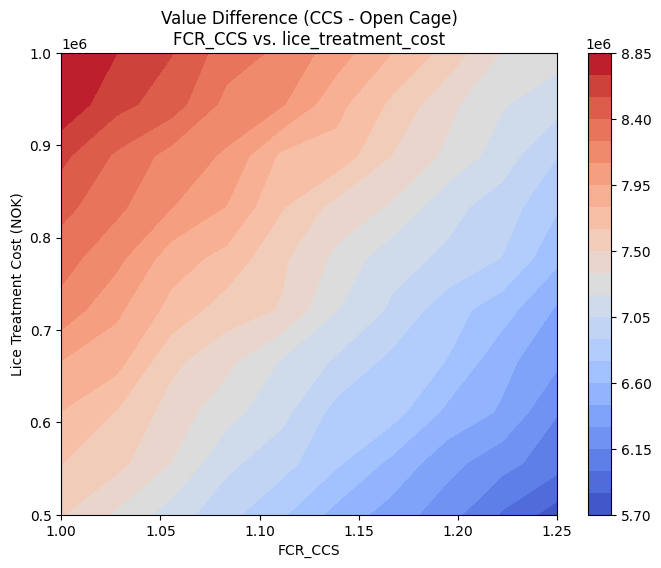

In [ ]:
# # Generate Heat Map 5: FCR_CCS vs lice_treatment_cost

# # Fixed parameters for this heat map
# fixed_mu_smoltification_inc_css = 0.2  # Fixed mu_smoltification_inc_css
# fixed_weight_mort_inc_css = 0.001      # Fixed weight_mort_inc_css
# fixed_c_CCS = 1.43                       # Fixed growth constant c_CCS

# # Define the parameter ranges
# FCR_CCS_values = np.linspace(1.0, 1.25, num=10)
# lice_treatment_cost_values = np.linspace(500000, 1000000, num=10)

# # Initialize an array to store the value differences
# value_difference = np.zeros((len(FCR_CCS_values), len(lice_treatment_cost_values)))

# for i, FCR_CCS_current in enumerate(FCR_CCS_values):
#     for j, lice_treatment_cost_current in enumerate(lice_treatment_cost_values):
#         # Simulate CCS (without lice)
#         results_CCS = simulate_paths(
#             num_simulations, harvesting_cost_per_kg, feed_cost_per_kg_year,
#             0, FCR_CCS_current, mu, fixed_c_CCS, fixed_mu_smoltification_inc_css,
#             fixed_weight_mort_inc_css, lice_treatment_cost_current, lambda_growth
#         )
#         (simulated_values_CCS, harvesting_costs_CCS, feed_costs_CCS, lice_per_fish_CCS,
#          treatment_costs_CCS, mortality_rate_CCS, cumulative_death_CCS, B_t_CCS, D_t_CCS) = results_CCS

#         knot_value_CCS, exercise_times_CCS, average_dead_weight_CCS, avg_mortality_rate_CCS = lsmc(
#             simulated_values_CCS, harvesting_costs_CCS, r, time_horizon, T,
#             B_t_CCS, D_t_CCS
#         )

#         # Simulate open cage (with lice)
#         results_open = simulate_paths(
#             num_simulations, harvesting_cost_per_kg, feed_cost_per_kg_year,
#             0.001, FCR, mu, c, mu_smoltification_inc, weight_mort_inc, lice_treatment_cost_current, lambda_growth
#         )
#         (simulated_values_open, harvesting_costs_open, feed_costs_open, lice_per_fish_open,
#          treatment_costs_open, mortality_rate_open, cumulative_death_open, B_t_open, D_t_open) = results_open

#         knot_value_open, exercise_times_open, average_dead_weight_open, avg_mortality_rate_open = lsmc(
#             simulated_values_open, harvesting_costs_open, r, time_horizon, T,
#             B_t_open, D_t_open
#         )

#         # Calculate value difference
#         value_diff = knot_value_CCS - knot_value_open
#         value_difference[i, j] = value_diff

#         print(f"FCR_CCS: {FCR_CCS_current:.2f}, lice_treatment_cost: {lice_treatment_cost_current:.0f}, Value Difference: {value_diff:.2f}")

# # Generate the heat map
# FCR_CCS_grid, lice_treatment_cost_grid = np.meshgrid(lice_treatment_cost_values, FCR_CCS_values)

# plt.figure(figsize=(8, 6))
# cp = plt.contourf(lice_treatment_cost_grid, FCR_CCS_grid, value_difference, levels=20, cmap='coolwarm')
# plt.colorbar(cp)
# plt.title('Value Difference (CCS - Open Cage)\nFCR_CCS vs. lice_treatment_cost')
# plt.xlabel('FCR_CCS')
# plt.ylabel('Lice Treatment Cost (NOK)')
# plt.show()

Testing lambda_growth = 5.00
lambda_growth: 5.00, Value Difference: 3395859.02
Testing lambda_growth = 5.17
lambda_growth: 5.17, Value Difference: 3666020.76
Testing lambda_growth = 5.34
lambda_growth: 5.34, Value Difference: 4011074.75
Testing lambda_growth = 5.52
lambda_growth: 5.52, Value Difference: 4435230.40
Testing lambda_growth = 5.69
lambda_growth: 5.69, Value Difference: 4808265.94
Testing lambda_growth = 5.86
lambda_growth: 5.86, Value Difference: 4959191.34
Testing lambda_growth = 6.03
lambda_growth: 6.03, Value Difference: 5092652.96
Testing lambda_growth = 6.21
lambda_growth: 6.21, Value Difference: 5263224.74
Testing lambda_growth = 6.38
lambda_growth: 6.38, Value Difference: 5443985.16
Testing lambda_growth = 6.55
lambda_growth: 6.55, Value Difference: 5634812.57
Testing lambda_growth = 6.72
lambda_growth: 6.72, Value Difference: 5880553.34
Testing lambda_growth = 6.90
lambda_growth: 6.90, Value Difference: 6185163.03
Testing lambda_growth = 7.07
lambda_growth: 7.07, Va

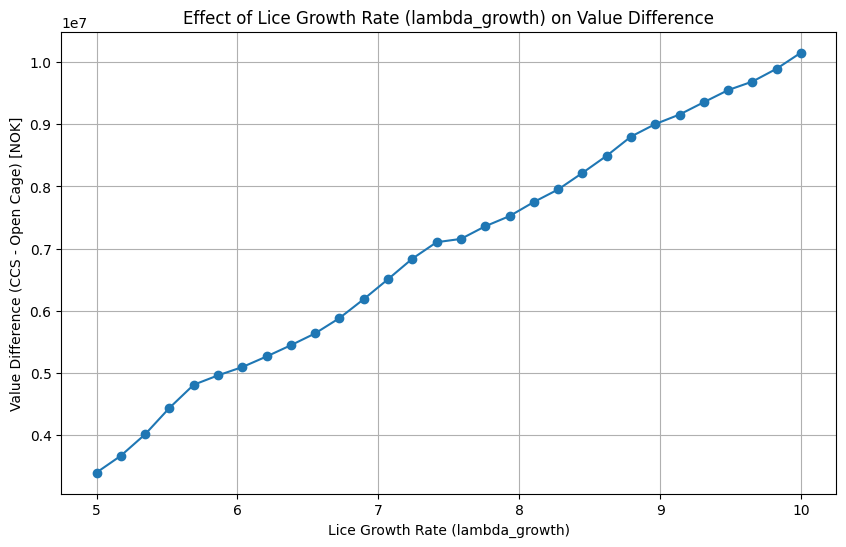

In [39]:
value_differences = np.zeros(len(lambda_growth_values))

for idx, lambda_growth_current in enumerate(lambda_growth_values):
    print(f"Testing lambda_growth = {lambda_growth_current:.2f}")

    # Simulate open cage (with lice)
    results_open = simulate_paths(
        num_simulations, harvesting_cost_per_kg, feed_cost_per_kg_year,
        0.001, FCR, mu, c, mu_smoltification_inc, weight_mort_inc, lice_treatment_cost, lambda_growth_current
    )
    (simulated_values_open, harvesting_costs_open, feed_costs_open, lice_per_fish_open, treatment_costs_open,
     mortality_rate_open, cumulative_death_open, B_t_open, D_t_open) = results_open

    knot_value_open, exercise_times_open, average_dead_weight_open, avg_mortality_rate_open = lsmc(
        simulated_values_open, harvesting_costs_open, r, time_horizon, T, B_t_open, D_t_open
    )

    # Simulate CCS (without lice, lambda_growth doesn't affect CCS since initial_lice_per_fish = 0)
    # However, for consistency, we'll pass lambda_growth_current
    results_CCS = simulate_paths(
        num_simulations, harvesting_cost_per_kg, feed_cost_per_kg_year,
        0, FCR, mu, c, mu_smoltification_inc, weight_mort_inc, lice_treatment_cost, lambda_growth_current
    )
    (simulated_values_CCS, harvesting_costs_CCS, feed_costs_CCS, lice_per_fish_CCS,
     treatment_costs_CCS, mortality_rate_CCS, cumulative_death_CCS, B_t_CCS, D_t_CCS) = results_CCS

    knot_value_CCS, exercise_times_CCS, average_dead_weight_CCS, avg_mortality_rate_CCS = lsmc(
        simulated_values_CCS, harvesting_costs_CCS, r, time_horizon, T, B_t_CCS, D_t_CCS
    )

    # Calculate value difference
    value_diff = knot_value_CCS - knot_value_open
    value_differences[idx] = value_diff

    print(f"lambda_growth: {lambda_growth_current:.2f}, Value Difference: {value_diff:.2f}")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(lambda_growth_values, value_differences, marker='o')
plt.title('Effect of Lice Growth Rate (lambda_growth) on Value Difference')
plt.xlabel('Lice Growth Rate (lambda_growth)')
plt.ylabel('Value Difference (CCS - Open Cage) [NOK]')
plt.grid(True)
plt.show()